In [28]:

import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm

from glob import glob

warnings.filterwarnings("ignore")

from matplotlib.ticker import FormatStrFormatter
#gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

sns.set(style='white',  font='sans-serif', font_scale=2)  

from statannot import add_stat_annotation


from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggMapNet



In [29]:
from time import time

In [30]:
def get_megma_time(dfx):
    t1 = time()
    mp = AggMap(dfx, by_scipy = True)
    mp = mp.fit(verbose = 0, var_thr = 0) 
    X = mp.batch_transform(dfx.values)
    t2 = time()
    megma_time = t2-t1
    
    return megma_time, X, mp

def get_AggMapNet_time(X, Y, **args):
    t1 = time()
    clf = AggMapNet.MultiClassEstimator(**args) #best epochs for dataset Cirrhosis
    clf.fit(X, Y)
    t2 = time()
    aggmapnet_time = t2-t1
    return aggmapnet_time



def get_RF_time(X, Y, best_params):
    t1 = time()
    clf = RandomForestClassifier(**best_params, random_state = 666)
    clf.fit(X, Y)  #, 
    t2 = time()
    rf_time = t2-t1
    return rf_time

In [58]:
data_path = '../01_data/species_level/Cirrhosis/'

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfb = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = np.log(dfa.T + 1e-4)
n, p = dfx.shape

dfy = dfb[0].map({'cirrhosis':1, 'n':0})
Y_rf = dfy.values

Y_net = pd.get_dummies(dfy).values


megma_time, X, mp = get_megma_time(dfx)

ag_best_params = {"epochs":18, 'batch_size':2}
aggmapnet_time = get_AggMapNet_time(X, Y_net, **ag_best_params) #best epochs for dataset Cirrhosis
X_rf = mp.transform_mpX_to_df(X)[mp.flist].values
rf_best_params = {"n_estimators":50,"min_samples_split":10,"min_samples_leaf":1,"max_features":"auto","max_depth":100,"bootstrap":True}

rf_time = get_RF_time(X_rf, Y_rf, rf_best_params)

2022-09-21 17:14:39,900 - INFO - [bidd-aggmap] - Calculating distance ...


100%|####################################################################################################################################| 542/542 [00:00<00:00, 5461.95it/s]

2022-09-21 17:14:40,012 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


2022-09-21 17:14:40,402 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-09-21 17:14:40,784 - INFO - [bidd-aggmap] - Finished


100%|####################################################################################################################################| 232/232 [00:00<00:00, 4209.91it/s]

MultiClassEstimator(batch_norm=False, batch_size=128, conv1_kernel_size=13,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=18, gpuid='0', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)


(232, 542, 1.5725126266479492, 3.6546993255615234, 0.09367585182189941)

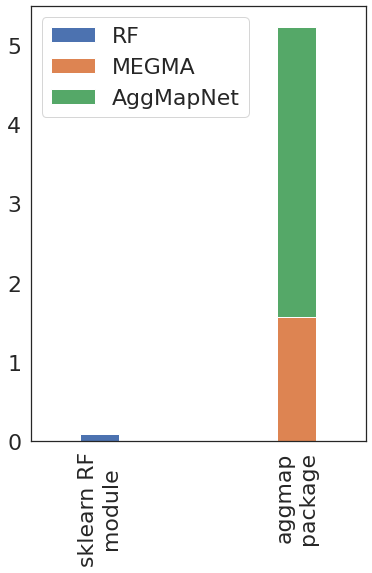

In [93]:
res = {'sklearn RF\nmodule': {'RF': rf_time}, 'aggmap\npackage': {'MEGMA':megma_time, 'AggMapNet':aggmapnet_time} }

fig, ax =plt.subplots(figsize = (6,8),)
pd.DataFrame(res).T.plot(kind='bar', stacked=True, ax =ax, width = 0.2) #hatch='x', 
n, p, megma_time, aggmapnet_time, rf_time